In [89]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder,  LabelEncoder, OrdinalEncoder 
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split, RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
from xgboost import XGBClassifier


from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


from scipy.stats import pointbiserialr


from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from collections import Counter



import joblib

from datetime import datetime


# 0- Importation du fichier merge preclean

In [90]:
df = pd.read_parquet(r'C:\Users\dimle\Documents\clone_repo\preventive_maintenance\data_preclean_avion_full_compo.parquet')

In [91]:
pd.set_option("display.max_columns", None)

In [92]:
df.head(3)

,aero_,measure_day_,usure_nouvelle_max_Ailerons,usure_nouvelle_max_Autopilote,usure_nouvelle_max_Détecteurs_de_fumée,usure_nouvelle_max_Empennage,usure_nouvelle_max_Flaps,usure_nouvelle_max_Freins,usure_nouvelle_max_Gouvernail_de_direction,usure_nouvelle_max_Générateur_électrique,usure_nouvelle_max_Hublots,usure_nouvelle_max_Ordinateur_de_vol,usure_nouvelle_max_Porte_cargo,usure_nouvelle_max_Portes_passagers,usure_nouvelle_max_Radar_météorologique,usure_nouvelle_max_Réacteur_droit,usure_nouvelle_max_Réacteur_gauche,usure_nouvelle_max_Siège_copilote,usure_nouvelle_max_Siège_pilote,usure_nouvelle_max_Spoilers,usure_nouvelle_max_Système_anti-givre,usure_nouvelle_max_Système_d'alerte_de_proximité_au_sol_(GPWS),usure_nouvelle_max_Système_d'annonce_publique,usure_nouvelle_max_Système_d'approvisionnement_en_eau,usure_nouvelle_max_Système_d'atterrissage_automatique,usure_nouvelle_max_Système_d'extinction_d'incendie,usure_nouvelle_max_Système_de_commande_des_gaz,usure_nouvelle_max_Système_de_communication_radio,usure_nouvelle_max_Système_de_conditionnement_d'air,usure_nouvelle_max_Système_de_contrôle_de_vol,usure_nouvelle_max_Système_de_contrôle_des_surfaces_de_vol,usure_nouvelle_max_Système_de_divertissement_en_vol,usure_nouvelle_max_Système_de_gestion_de_carburant,usure_nouvelle_max_Système_de_gestion_électrique,usure_nouvelle_max_Système_de_navigation,usure_nouvelle_max_Système_de_pressurisation,usure_nouvelle_max_Système_de_surveillance_du_trafic_aérien,usure_nouvelle_max_Système_hydraulique_principal,usure_nouvelle_max_Systèmes_d'oxygène_d'urgence,usure_nouvelle_max_Toilettes,usure_nouvelle_max_Train_d'atterrissage_avant,usure_nouvelle_max_Train_d'atterrissage_principal,usure_nouvelle_max_Unité_de_gestion_de_l'air,usure_nouvelle_max_Éclairage_d'urgence,usure_nouvelle_max_Éclairage_de_cabine,usure_nouvelle_max_Éclairage_de_la_cabine,usure_nouvelle_mean_Ailerons,usure_nouvelle_mean_Autopilote,usure_nouvelle_mean_Détecteurs_de_fumée,usure_nouvelle_mean_Empennage,usure_nouvelle_mean_Flaps,usure_nouvelle_mean_Freins,usure_nouvelle_mean_Gouvernail_de_direction,usure_nouvelle_mean_Générateur_électrique,usure_nouvelle_mean_Hublots,usure_nouvelle_mean_Ordinateur_de_vol,usure_nouvelle_mean_Porte_cargo,usure_nouvelle_mean_Portes_passagers,usure_nouvelle_mean_Radar_météorologique,usure_nouvelle_mean_Réacteur_droit,usure_nouvelle_mean_Réacteur_gauche,usure_nouvelle_mean_Siège_copilote,usure_nouvelle_mean_Siège_pilote,usure_nouvelle_mean_Spoilers,usure_nouvelle_mean_Système_anti-givre,usure_nouvelle_mean_Système_d'alerte_de_proximité_au_sol_(GPWS),usure_nouvelle_mean_Système_d'annonce_publique,usure_nouvelle_mean_Système_d'approvisionnement_en_eau,usure_nouvelle_mean_Système_d'atterrissage_automatique,usure_nouvelle_mean_Système_d'extinction_d'incendie,usure_nouvelle_mean_Système_de_commande_des_gaz,usure_nouvelle_mean_Système_de_communication_radio,usure_nouvelle_mean_Système_de_conditionnement_d'air,usure_nouvelle_mean_Système_de_contrôle_de_vol,usure_nouvelle_mean_Système_de_contrôle_des_surfaces_de_vol,usure_nouvelle_mean_Système_de_divertissement_en_vol,usure_nouvelle_mean_Système_de_gestion_de_carburant,usure_nouvelle_mean_Système_de_gestion_électrique,usure_nouvelle_mean_Système_de_navigation,usure_nouvelle_mean_Système_de_pressurisation,usure_nouvelle_mean_Système_de_surveillance_du_trafic_aérien,usure_nouvelle_mean_Système_hydraulique_principal,usure_nouvelle_mean_Systèmes_d'oxygène_d'urgence,usure_nouvelle_mean_Toilettes,usure_nouvelle_mean_Train_d'atterrissage_avant,usure_nouvelle_mean_Train_d'atterrissage_principal,usure_nouvelle_mean_Unité_de_gestion_de_l'air,usure_nouvelle_mean_Éclairage_d'urgence,usure_nouvelle_mean_Éclairage_de_cabine,usure_nouvelle_mean_Éclairage_de_la_cabine,time_en_air,etat_voyant,temp,pressure,vibrations,type_model,debut_service,last_maint,en_maintenance,measure_day,temps_de_vol_cumule,etat_voyant_suivant
0,A320_1884,2024-06-04,24.424320,30.542460,6.841880,36.802480,17.114500,17.502700,40.335740,30.028880,28

# 1- clean du dataset pour le ML

In [93]:
df['measure_day_'] = pd.to_datetime(df['measure_day_'])
df['last_maint'] = pd.to_datetime(df['last_maint'])

In [94]:
# ajouter la colonne nb de jour depuis la derniere maintenande
# measure_day_ - last_maint

df['nb_jours_maint'] = df.apply(lambda x: x['measure_day_'] - x['last_maint'], axis=1)

In [95]:
# ajout du nombre de jour depuis la mise en service à jour_vol
df['nb_jours_service'] = df.apply(lambda x: x['measure_day_'] - x['debut_service'], axis=1)

In [96]:
# suppression des colonnes date inutile
df = df.drop(columns=['measure_day', 'last_maint', 'debut_service', 'etat_voyant_suivant'])

In [97]:
# modification du type de variable pour les ecarts de date (passage en integer depuis un timedelta64[ns] en jour)
df['nb_jours_maint'] = df['nb_jours_maint'].dt.days
df['nb_jours_service'] = df['nb_jours_service'].dt.days

In [98]:
df.head(2)

,aero_,measure_day_,usure_nouvelle_max_Ailerons,usure_nouvelle_max_Autopilote,usure_nouvelle_max_Détecteurs_de_fumée,usure_nouvelle_max_Empennage,usure_nouvelle_max_Flaps,usure_nouvelle_max_Freins,usure_nouvelle_max_Gouvernail_de_direction,usure_nouvelle_max_Générateur_électrique,usure_nouvelle_max_Hublots,usure_nouvelle_max_Ordinateur_de_vol,usure_nouvelle_max_Porte_cargo,usure_nouvelle_max_Portes_passagers,usure_nouvelle_max_Radar_météorologique,usure_nouvelle_max_Réacteur_droit,usure_nouvelle_max_Réacteur_gauche,usure_nouvelle_max_Siège_copilote,usure_nouvelle_max_Siège_pilote,usure_nouvelle_max_Spoilers,usure_nouvelle_max_Système_anti-givre,usure_nouvelle_max_Système_d'alerte_de_proximité_au_sol_(GPWS),usure_nouvelle_max_Système_d'annonce_publique,usure_nouvelle_max_Système_d'approvisionnement_en_eau,usure_nouvelle_max_Système_d'atterrissage_automatique,usure_nouvelle_max_Système_d'extinction_d'incendie,usure_nouvelle_max_Système_de_commande_des_gaz,usure_nouvelle_max_Système_de_communication_radio,usure_nouvelle_max_Système_de_conditionnement_d'air,usure_nouvelle_max_Système_de_contrôle_de_vol,usure_nouvelle_max_Système_de_contrôle_des_surfaces_de_vol,usure_nouvelle_max_Système_de_divertissement_en_vol,usure_nouvelle_max_Système_de_gestion_de_carburant,usure_nouvelle_max_Système_de_gestion_électrique,usure_nouvelle_max_Système_de_navigation,usure_nouvelle_max_Système_de_pressurisation,usure_nouvelle_max_Système_de_surveillance_du_trafic_aérien,usure_nouvelle_max_Système_hydraulique_principal,usure_nouvelle_max_Systèmes_d'oxygène_d'urgence,usure_nouvelle_max_Toilettes,usure_nouvelle_max_Train_d'atterrissage_avant,usure_nouvelle_max_Train_d'atterrissage_principal,usure_nouvelle_max_Unité_de_gestion_de_l'air,usure_nouvelle_max_Éclairage_d'urgence,usure_nouvelle_max_Éclairage_de_cabine,usure_nouvelle_max_Éclairage_de_la_cabine,usure_nouvelle_mean_Ailerons,usure_nouvelle_mean_Autopilote,usure_nouvelle_mean_Détecteurs_de_fumée,usure_nouvelle_mean_Empennage,usure_nouvelle_mean_Flaps,usure_nouvelle_mean_Freins,usure_nouvelle_mean_Gouvernail_de_direction,usure_nouvelle_mean_Générateur_électrique,usure_nouvelle_mean_Hublots,usure_nouvelle_mean_Ordinateur_de_vol,usure_nouvelle_mean_Porte_cargo,usure_nouvelle_mean_Portes_passagers,usure_nouvelle_mean_Radar_météorologique,usure_nouvelle_mean_Réacteur_droit,usure_nouvelle_mean_Réacteur_gauche,usure_nouvelle_mean_Siège_copilote,usure_nouvelle_mean_Siège_pilote,usure_nouvelle_mean_Spoilers,usure_nouvelle_mean_Système_anti-givre,usure_nouvelle_mean_Système_d'alerte_de_proximité_au_sol_(GPWS),usure_nouvelle_mean_Système_d'annonce_publique,usure_nouvelle_mean_Système_d'approvisionnement_en_eau,usure_nouvelle_mean_Système_d'atterrissage_automatique,usure_nouvelle_mean_Système_d'extinction_d'incendie,usure_nouvelle_mean_Système_de_commande_des_gaz,usure_nouvelle_mean_Système_de_communication_radio,usure_nouvelle_mean_Système_de_conditionnement_d'air,usure_nouvelle_mean_Système_de_contrôle_de_vol,usure_nouvelle_mean_Système_de_contrôle_des_surfaces_de_vol,usure_nouvelle_mean_Système_de_divertissement_en_vol,usure_nouvelle_mean_Système_de_gestion_de_carburant,usure_nouvelle_mean_Système_de_gestion_électrique,usure_nouvelle_mean_Système_de_navigation,usure_nouvelle_mean_Système_de_pressurisation,usure_nouvelle_mean_Système_de_surveillance_du_trafic_aérien,usure_nouvelle_mean_Système_hydraulique_principal,usure_nouvelle_mean_Systèmes_d'oxygène_d'urgence,usure_nouvelle_mean_Toilettes,usure_nouvelle_mean_Train_d'atterrissage_avant,usure_nouvelle_mean_Train_d'atterrissage_principal,usure_nouvelle_mean_Unité_de_gestion_de_l'air,usure_nouvelle_mean_Éclairage_d'urgence,usure_nouvelle_mean_Éclairage_de_cabine,usure_nouvelle_mean_Éclairage_de_la_cabine,time_en_air,etat_voyant,temp,pressure,vibrations,type_model,en_maintenance,temps_de_vol_cumule,nb_jours_maint,nb_jours_service
0,A320_1884,2024-06-04,24.424320,30.542460,6.841880,36.802480,17.11450,17.50270,40.335740,30.028880,28.256040,36.529380,28.500460

In [99]:
df.isna().sum()

aero_                                     0
measure_day_                              0
usure_nouvelle_max_Ailerons               0
usure_nouvelle_max_Autopilote             0
usure_nouvelle_max_Détecteurs_de_fumée    0
                                         ..
type_model                                0
en_maintenance                            0
temps_de_vol_cumule                       0
nb_jours_maint                            0
nb_jours_service                          0
Length: 100, dtype: int64

In [100]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
measure_day_,5520,2024-06-29 15:38:05.217391360,2024-06-02 00:00:00,2024-06-16 00:00:00,2024-06-30 00:00:00,2024-07-14 00:00:00,2024-07-26 00:00:00,NaN
usure_nouvelle_max_Ailerons,5520.0,34.709003,0.900392,18.775869,33.049056,49.754534,75.576524,18.328182
usure_nouvelle_max_Autopilote,5520.0,39.580568,1.184492,24.810241,38.905826,54.544265,79.838052,17.999124
usure_nouvelle_max_Détecteurs_de_fumée,5520.0,40.195765,0.619696,25.80398,40.80224,55.795625,82.491952,17.818322
usure_nouvelle_max_Empennage,5520.0,39.180734,1.868096,24.85393,39.427916,53.416858,81.82632,17.505923
...,...,...,...,...,...,...,...,...
pressure,5520.0,950.724366,757.3,917.1,951.4,984.8,1109.5,49.361462
vibrations,5520.0,2.519678,0.001847,1.270467,2.531227,3.77367,4.999276,1.453189
temps_de_vol_cumule,5520.0,23.720435,0.6,9.2,18.6,33.125,114.1,18.835484
nb_jours_maint,5520.0,79.791667,0.0,25.0,48.0,130.0,387.0,72.884879


# 1.bis- Visualisation des data 

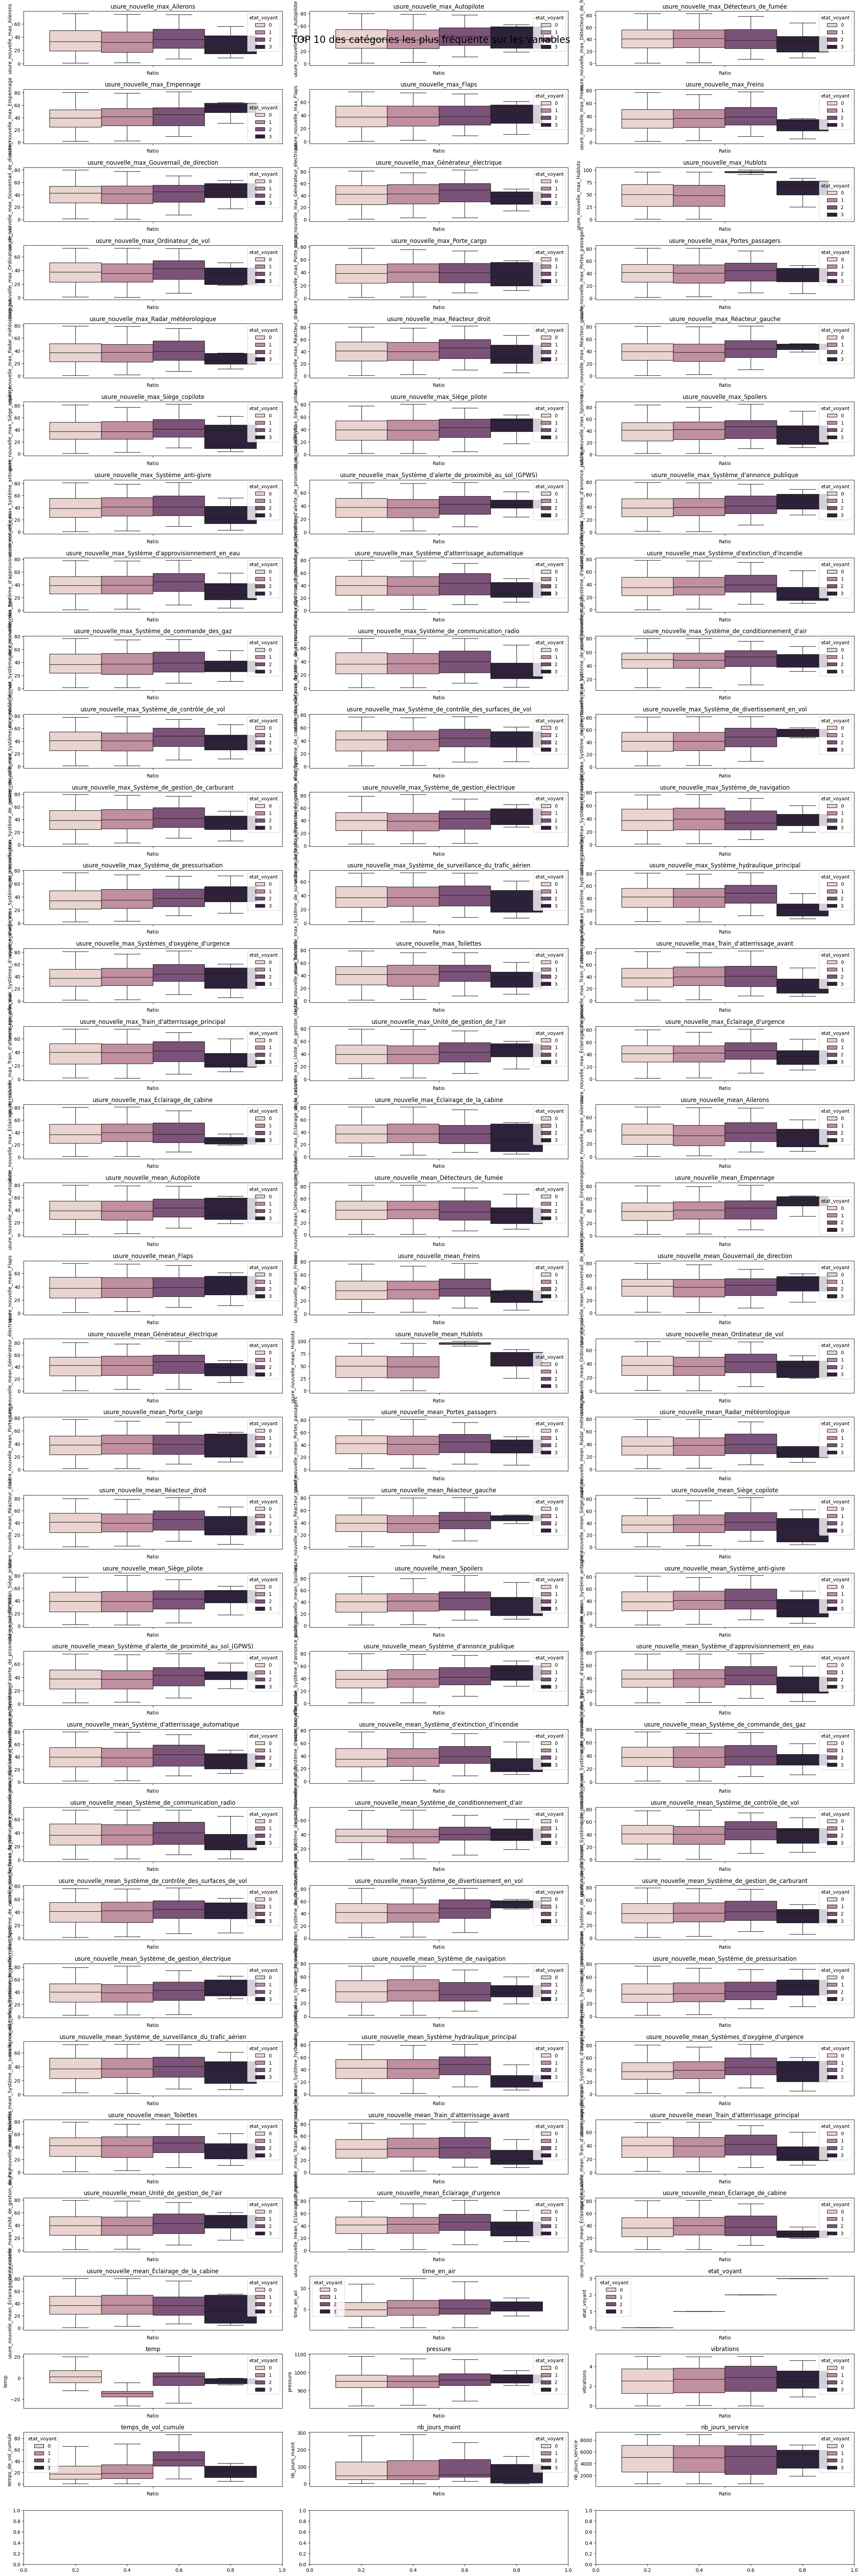

In [101]:
df_num = df.select_dtypes('number')

# Créer une figure avec des sous-graphiques
fig, axes = plt.subplots(33, 3, figsize=(25, 75))
fig.suptitle('TOP 10 des catégories les plus fréquente sur les variables', fontsize=20)
fig.tight_layout(pad=3.0)

# Parcourir chaque colonne et créer un histogramme
for i, col in enumerate(df_num.columns):
    

    sns.boxplot(data=df, y=col,  ax=axes[i//3, i%3], hue='etat_voyant', showfliers= False)
    axes[i//3, i%3].set_title(col)
    axes[i//3, i%3].set_xlabel('Ratio')
    axes[i//3, i%3].set_ylabel(col)

plt.tight_layout()
plt.show()

In [102]:
# fig_correl, ax_correl = plt.subplots(1,1, figsize = (20,10))

# numerical_corr_matrix = df.select_dtypes(include='number').corr()

# mask = np.triu(np.ones_like(numerical_corr_matrix, dtype=bool))

# annot_kwargs = {
#     "fontsize": 12
# }

# sns.heatmap(numerical_corr_matrix,
#                 center= 0,
#                 cmap = sns.color_palette("vlag", as_cmap=True),
#                 annot= True,
#                 mask= mask,
#                 ax=ax_correl,
#                 linewidths=.5,
#                 fmt= '.2f',
#                 annot_kws= annot_kwargs
#                 )

# ax_correl.set_title('Matrice de corrélation pour Voyant tous les voyants', fontsize= 15)
# ax_correl.set_xticklabels(ax_correl.get_xticklabels(), fontsize=10, rotation = 40)
# ax_correl.set_yticklabels(ax_correl.get_xticklabels(), fontsize=10, rotation = 0)

# plt.show(fig_correl.figure)

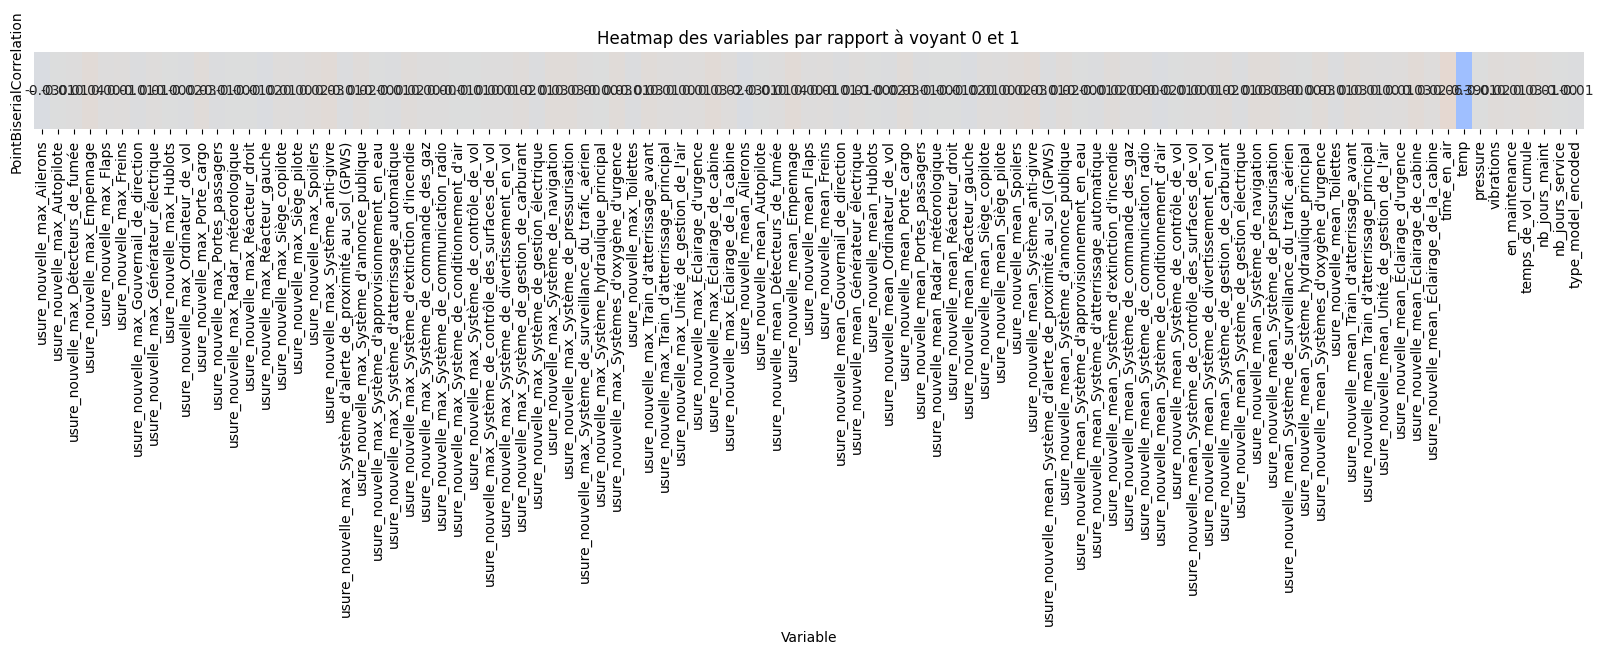

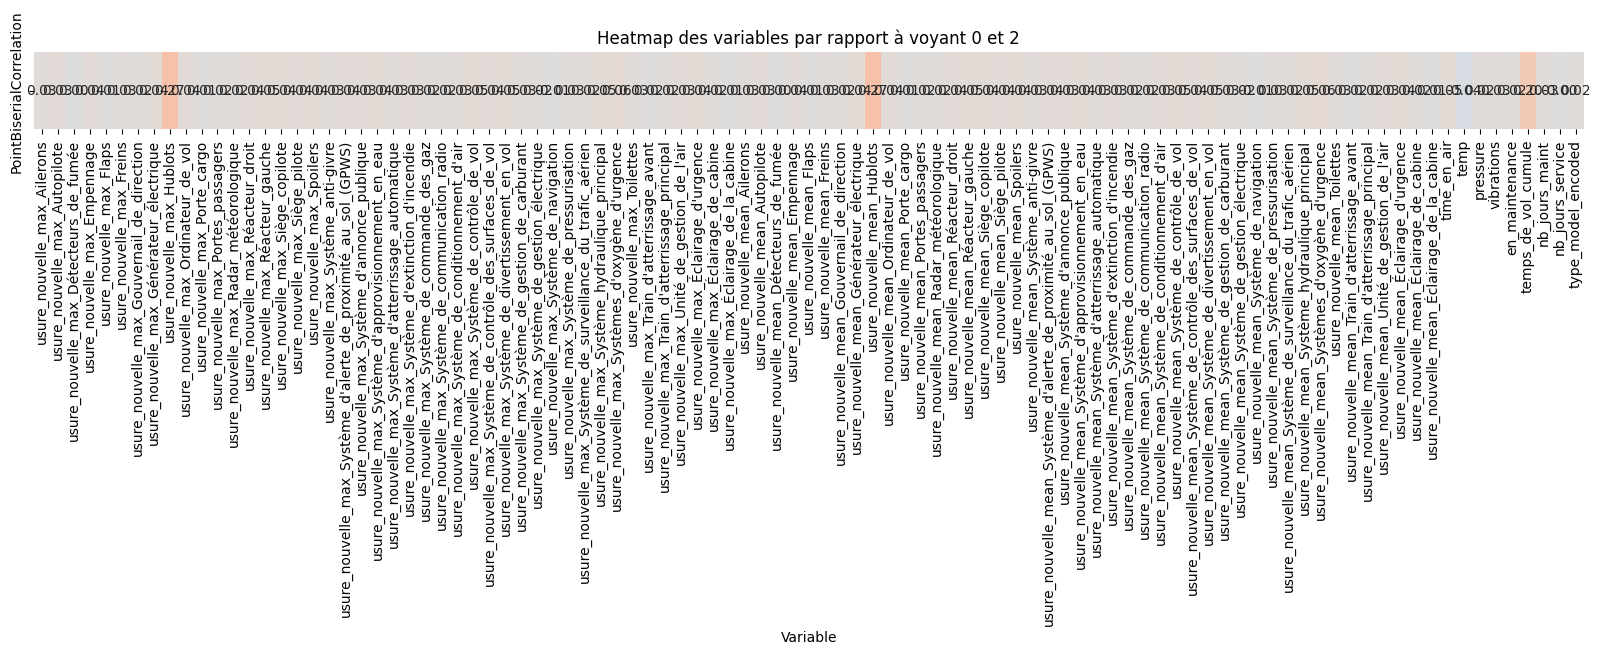

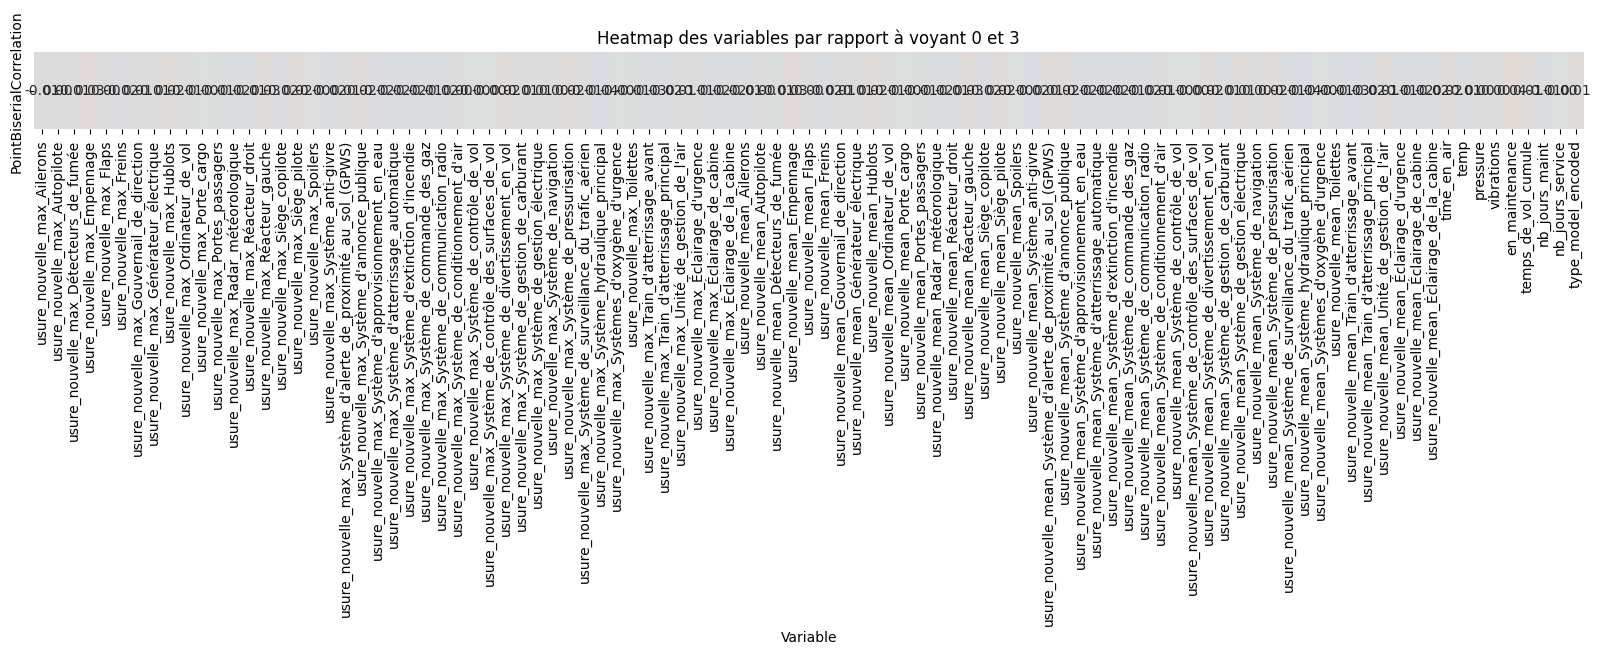

In [103]:
# encodage 0 ou 1 pour la class etat_voyant trié à 3

label_encoder = LabelEncoder()

for i in range(0,4,1):
    if i!=0:

        df_3 = df[(df['etat_voyant']==i) | (df['etat_voyant']==0)].copy()

        df_3['etat_voyant_encoded'] = label_encoder.fit_transform(df_3['etat_voyant'])
        df_3['type_model_encoded'] = label_encoder.fit_transform(df_3['type_model'])

        df_3.drop(['etat_voyant', 'type_model', 'measure_day_'], axis=1, inplace=True)

        continuous_cols = df_3.drop(columns=['etat_voyant_encoded', 'aero_' ])

        # Calculer la corrélation bisériale ponctuelle pour chaque variable continue
        correlations = {}

        for col in continuous_cols.columns:

            correlations[col] = pointbiserialr(df_3['etat_voyant_encoded'], df_3[col])[0]


        # Convertir le dictionnaire en DataFrame pour la heatmap
        corr_df = pd.DataFrame(list(correlations.items()), columns=['Variable', 'PointBiserialCorrelation'])
        corr_df.set_index('Variable', inplace=True)


        plt.figure(figsize=(20, 1))
        sns.heatmap(corr_df.T, annot=True, cmap='coolwarm', cbar=False, fmt=".2f", vmin=-1, vmax= 1)
        plt.title(f'Heatmap des variables par rapport à voyant {0} et {i}')


        plt.show()

# 2- Prepa des données et pipeline pour ML

In [104]:
df.select_dtypes(exclude='number').columns


Index(['aero_', 'measure_day_', 'type_model', 'en_maintenance'], dtype='object')

In [105]:
features_std = [
'usure_nouvelle_max_Ailerons', 
'usure_nouvelle_max_Autopilote',
       'usure_nouvelle_max_Détecteurs_de_fumée',
       'usure_nouvelle_max_Empennage', 
       'usure_nouvelle_max_Flaps',
       'usure_nouvelle_max_Freins',
       'usure_nouvelle_max_Gouvernail_de_direction',
       'usure_nouvelle_max_Générateur_électrique',
       'usure_nouvelle_max_Hublots', 
       'usure_nouvelle_max_Ordinateur_de_vol',
       'usure_nouvelle_max_Porte_cargo', 
       'usure_nouvelle_max_Portes_passagers',
       'usure_nouvelle_max_Radar_météorologique',
       'usure_nouvelle_max_Réacteur_droit',
       'usure_nouvelle_max_Réacteur_gauche',
       'usure_nouvelle_max_Siège_copilote', 
       'usure_nouvelle_max_Siège_pilote',
       'usure_nouvelle_max_Spoilers', 
       'usure_nouvelle_max_Système_anti-givre',
       'usure_nouvelle_max_Système_d\'alerte_de_proximité_au_sol_(GPWS)',
       'usure_nouvelle_max_Système_d\'annonce_publique',
       'usure_nouvelle_max_Système_d\'approvisionnement_en_eau',
       'usure_nouvelle_max_Système_d\'atterrissage_automatique',
       'usure_nouvelle_max_Système_d\'extinction_d\'incendie',
       'usure_nouvelle_max_Système_de_commande_des_gaz',
       'usure_nouvelle_max_Système_de_communication_radio',
       'usure_nouvelle_max_Système_de_conditionnement_d\'air',
       'usure_nouvelle_max_Système_de_contrôle_de_vol',
       'usure_nouvelle_max_Système_de_contrôle_des_surfaces_de_vol',
       'usure_nouvelle_max_Système_de_divertissement_en_vol',
       'usure_nouvelle_max_Système_de_gestion_de_carburant',
       'usure_nouvelle_max_Système_de_gestion_électrique',
       'usure_nouvelle_max_Système_de_navigation',
       'usure_nouvelle_max_Système_de_pressurisation',
       'usure_nouvelle_max_Système_de_surveillance_du_trafic_aérien',
       'usure_nouvelle_max_Système_hydraulique_principal',
       'usure_nouvelle_max_Systèmes_d\'oxygène_d\'urgence',
       'usure_nouvelle_max_Toilettes',
       'usure_nouvelle_max_Train_d\'atterrissage_avant',
       'usure_nouvelle_max_Train_d\'atterrissage_principal',
       'usure_nouvelle_max_Unité_de_gestion_de_l\'air',
       'usure_nouvelle_max_Éclairage_d\'urgence',
       'usure_nouvelle_max_Éclairage_de_cabine',
       'usure_nouvelle_max_Éclairage_de_la_cabine',
       'usure_nouvelle_mean_Ailerons', 
       'usure_nouvelle_mean_Autopilote',
       'usure_nouvelle_mean_Détecteurs_de_fumée',
       'usure_nouvelle_mean_Empennage', 
       'usure_nouvelle_mean_Flaps',
       'usure_nouvelle_mean_Freins',
       'usure_nouvelle_mean_Gouvernail_de_direction',
       'usure_nouvelle_mean_Générateur_électrique',
       'usure_nouvelle_mean_Hublots', 
       'usure_nouvelle_mean_Ordinateur_de_vol',
       'usure_nouvelle_mean_Porte_cargo',
       'usure_nouvelle_mean_Portes_passagers',
       'usure_nouvelle_mean_Radar_météorologique',
       'usure_nouvelle_mean_Réacteur_droit',
       'usure_nouvelle_mean_Réacteur_gauche',
       'usure_nouvelle_mean_Siège_copilote',
       'usure_nouvelle_mean_Siège_pilote', 
       'usure_nouvelle_mean_Spoilers',
       'usure_nouvelle_mean_Système_anti-givre',
       'usure_nouvelle_mean_Système_d\'alerte_de_proximité_au_sol_(GPWS)',
       'usure_nouvelle_mean_Système_d\'annonce_publique',
       'usure_nouvelle_mean_Système_d\'approvisionnement_en_eau',
       'usure_nouvelle_mean_Système_d\'atterrissage_automatique',
       'usure_nouvelle_mean_Système_d\'extinction_d\'incendie',
       'usure_nouvelle_mean_Système_de_commande_des_gaz',
       'usure_nouvelle_mean_Système_de_communication_radio',
       'usure_nouvelle_mean_Système_de_conditionnement_d\'air',
       'usure_nouvelle_mean_Système_de_contrôle_de_vol',
       'usure_nouvelle_mean_Système_de_contrôle_des_surfaces_de_vol',
       'usure_nouvelle_mean_Système_de_divertissement_en_vol',
       'usure_nouvelle_mean_Système_de_gestion_de_carburant',
       'usure_nouvelle_mean_Système_de_gestion_électrique',
       'usure_nouvelle_mean_Système_de_navigation',
       'usure_nouvelle_mean_Système_de_pressurisation',
       'usure_nouvelle_mean_Système_de_surveillance_du_trafic_aérien',
       'usure_nouvelle_mean_Système_hydraulique_principal',
       'usure_nouvelle_mean_Systèmes_d\'oxygène_d\'urgence',
       'usure_nouvelle_mean_Toilettes',
       'usure_nouvelle_mean_Train_d\'atterrissage_avant',
       'usure_nouvelle_mean_Train_d\'atterrissage_principal',
       'usure_nouvelle_mean_Unité_de_gestion_de_l\'air',
       'usure_nouvelle_mean_Éclairage_d\'urgence',
       'usure_nouvelle_mean_Éclairage_de_cabine',
       'usure_nouvelle_mean_Éclairage_de_la_cabine', 
       'time_en_air',
       'temp', 
       'pressure', 
       'vibrations', 
       'temps_de_vol_cumule',
       'nb_jours_maint', 
       'nb_jours_service'
]

features_oneHot = ['type_model']


features_binar =['en_maintenance']

In [106]:
# Préparation des transformateurs pour les caractéristiques numériques
numeric_transformer_std = (ImbPipeline( steps= [
    ('stdScaller', StandardScaler())
]))

categ_transformer_onehot = (ImbPipeline( steps= [
    ('OneHot', OneHotEncoder())
]))

categ_transformer_bin = (ImbPipeline( steps= [
    ('bina', OrdinalEncoder())
]))


# Combinaison des transformation pour le preprocessing
preprocessor = ColumnTransformer(
    transformers= [
        ('num_std', numeric_transformer_std, features_std),
        ('cat_oneHot', categ_transformer_onehot, features_oneHot),
        ('cat_bin', categ_transformer_bin, features_binar)
    ]
)

In [107]:
y = df['etat_voyant'] 

X = df[['usure_nouvelle_max_Ailerons', 
'usure_nouvelle_max_Autopilote',
       'usure_nouvelle_max_Détecteurs_de_fumée',
       'usure_nouvelle_max_Empennage', 
       'usure_nouvelle_max_Flaps',
       'usure_nouvelle_max_Freins',
       'usure_nouvelle_max_Gouvernail_de_direction',
       'usure_nouvelle_max_Générateur_électrique',
       'usure_nouvelle_max_Hublots', 
       'usure_nouvelle_max_Ordinateur_de_vol',
       'usure_nouvelle_max_Porte_cargo', 
       'usure_nouvelle_max_Portes_passagers',
       'usure_nouvelle_max_Radar_météorologique',
       'usure_nouvelle_max_Réacteur_droit',
       'usure_nouvelle_max_Réacteur_gauche',
       'usure_nouvelle_max_Siège_copilote', 
       'usure_nouvelle_max_Siège_pilote',
       'usure_nouvelle_max_Spoilers', 
       'usure_nouvelle_max_Système_anti-givre',
       'usure_nouvelle_max_Système_d\'alerte_de_proximité_au_sol_(GPWS)',
       'usure_nouvelle_max_Système_d\'annonce_publique',
       'usure_nouvelle_max_Système_d\'approvisionnement_en_eau',
       'usure_nouvelle_max_Système_d\'atterrissage_automatique',
       'usure_nouvelle_max_Système_d\'extinction_d\'incendie',
       'usure_nouvelle_max_Système_de_commande_des_gaz',
       'usure_nouvelle_max_Système_de_communication_radio',
       'usure_nouvelle_max_Système_de_conditionnement_d\'air',
       'usure_nouvelle_max_Système_de_contrôle_de_vol',
       'usure_nouvelle_max_Système_de_contrôle_des_surfaces_de_vol',
       'usure_nouvelle_max_Système_de_divertissement_en_vol',
       'usure_nouvelle_max_Système_de_gestion_de_carburant',
       'usure_nouvelle_max_Système_de_gestion_électrique',
       'usure_nouvelle_max_Système_de_navigation',
       'usure_nouvelle_max_Système_de_pressurisation',
       'usure_nouvelle_max_Système_de_surveillance_du_trafic_aérien',
       'usure_nouvelle_max_Système_hydraulique_principal',
       'usure_nouvelle_max_Systèmes_d\'oxygène_d\'urgence',
       'usure_nouvelle_max_Toilettes',
       'usure_nouvelle_max_Train_d\'atterrissage_avant',
       'usure_nouvelle_max_Train_d\'atterrissage_principal',
       'usure_nouvelle_max_Unité_de_gestion_de_l\'air',
       'usure_nouvelle_max_Éclairage_d\'urgence',
       'usure_nouvelle_max_Éclairage_de_cabine',
       'usure_nouvelle_max_Éclairage_de_la_cabine',
       'usure_nouvelle_mean_Ailerons', 
       'usure_nouvelle_mean_Autopilote',
       'usure_nouvelle_mean_Détecteurs_de_fumée',
       'usure_nouvelle_mean_Empennage', 
       'usure_nouvelle_mean_Flaps',
       'usure_nouvelle_mean_Freins',
       'usure_nouvelle_mean_Gouvernail_de_direction',
       'usure_nouvelle_mean_Générateur_électrique',
       'usure_nouvelle_mean_Hublots', 
       'usure_nouvelle_mean_Ordinateur_de_vol',
       'usure_nouvelle_mean_Porte_cargo',
       'usure_nouvelle_mean_Portes_passagers',
       'usure_nouvelle_mean_Radar_météorologique',
       'usure_nouvelle_mean_Réacteur_droit',
       'usure_nouvelle_mean_Réacteur_gauche',
       'usure_nouvelle_mean_Siège_copilote',
       'usure_nouvelle_mean_Siège_pilote', 
       'usure_nouvelle_mean_Spoilers',
       'usure_nouvelle_mean_Système_anti-givre',
       'usure_nouvelle_mean_Système_d\'alerte_de_proximité_au_sol_(GPWS)',
       'usure_nouvelle_mean_Système_d\'annonce_publique',
       'usure_nouvelle_mean_Système_d\'approvisionnement_en_eau',
       'usure_nouvelle_mean_Système_d\'atterrissage_automatique',
       'usure_nouvelle_mean_Système_d\'extinction_d\'incendie',
       'usure_nouvelle_mean_Système_de_commande_des_gaz',
       'usure_nouvelle_mean_Système_de_communication_radio',
       'usure_nouvelle_mean_Système_de_conditionnement_d\'air',
       'usure_nouvelle_mean_Système_de_contrôle_de_vol',
       'usure_nouvelle_mean_Système_de_contrôle_des_surfaces_de_vol',
       'usure_nouvelle_mean_Système_de_divertissement_en_vol',
       'usure_nouvelle_mean_Système_de_gestion_de_carburant',
       'usure_nouvelle_mean_Système_de_gestion_électrique',
       'usure_nouvelle_mean_Système_de_navigation',
       'usure_nouvelle_mean_Système_de_pressurisation',
       'usure_nouvelle_mean_Système_de_surveillance_du_trafic_aérien',
       'usure_nouvelle_mean_Système_hydraulique_principal',
       'usure_nouvelle_mean_Systèmes_d\'oxygène_d\'urgence',
       'usure_nouvelle_mean_Toilettes',
       'usure_nouvelle_mean_Train_d\'atterrissage_avant',
       'usure_nouvelle_mean_Train_d\'atterrissage_principal',
       'usure_nouvelle_mean_Unité_de_gestion_de_l\'air',
       'usure_nouvelle_mean_Éclairage_d\'urgence',
       'usure_nouvelle_mean_Éclairage_de_cabine',
       'usure_nouvelle_mean_Éclairage_de_la_cabine', 
       'time_en_air',
       'temp', 
       'pressure', 
       'vibrations', 
       'temps_de_vol_cumule',
       'nb_jours_maint', 
       'nb_jours_service',
       'type_model',
       'en_maintenance'
       ]]

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify = y)

# 3- Essai de modele

## 3.1- Logistic regression

In [109]:
RL_model = XGBClassifier()

In [110]:
pipeline_reg_log = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(k_neighbors=3, random_state=42)),
    ('model', RL_model)
])

In [111]:
param_dist_xgbc = {
    'model__n_estimators': [50, 100, 200, 300, 400, 500],
    'model__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4],
    'model__max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'model__subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'model__colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'model__colsample_bylevel': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'model__colsample_bynode': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'model__gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'model__min_child_weight': [1, 2, 3, 4, 5, 6],
    'model__reg_alpha': [0, 0.01, 0.1, 1, 10],
    'model__reg_lambda': [1, 0.1, 0.01, 0.001, 0],
    'model__eval_metric': ['mlogloss', 'logloss'],
}


In [112]:
random_search_xgbc = RandomizedSearchCV(
    estimator=pipeline_reg_log,
    param_distributions=param_dist_xgbc,
    n_iter=50,  
    scoring='accuracy',
    verbose=1,
    random_state=42,
    cv=5,
    n_jobs=-1  
)

{'recall_micro', 'neg_mean_absolute_error', 'jaccard_micro', 'neg_root_mean_squared_error', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'balanced_accuracy', 'neg_mean_squared_log_error', 'f1_weighted', 'roc_auc', 'neg_mean_squared_error', 'explained_variance', 'r2', 'recall', 'recall_weighted', 'completeness_score', 'precision_macro', 'neg_brier_score', 'precision', 'neg_mean_gamma_deviance', 'f1_samples', 'f1_macro', 'homogeneity_score', 'recall_samples', 'd2_absolute_error_score', 'v_measure_score', 'precision_samples', 'accuracy', 'roc_auc_ovo_weighted', 'max_error', 'adjusted_mutual_info_score', 'neg_root_mean_squared_log_error', 'jaccard_weighted', 'jaccard_samples', 'positive_likelihood_ratio', 'neg_mean_poisson_deviance', 'neg_negative_likelihood_ratio', 'roc_auc_ovr', 'average_precision', 'precision_weighted', 'neg_mean_absolute_percentage_error', 'neg_median_absolute_error', 'precision_micro', 'neg_log_loss', 'f1', 'matthews_corrcoef', 'rand_score', 'fowlkes_mallows_score', 'jaccard', 'normalized_mutual_info_score', 'top_k_accuracy', 'adjusted_rand_score', 'jaccard_macro', 'f1_micro', 'mutual_info_score', 'recall_macro'}

In [113]:
random_search_xgbc.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num_std',
                                                                               Pipeline(steps=[('stdScaller',
                                                                                                StandardScaler())]),
                                                                               ['usure_nouvelle_max_Ailerons',
                                                                                'usure_nouvelle_max_Autopilote',
                                                                                'usure_nouvelle_max_Détecteurs_de_fumée',
                                                                                'usure_nouvelle_max_Empennage',
                                                                                'usure_nouvelle_max_Flaps',
                                                                                'usure_nouvelle_max_Freins',
                                                                                '...
                                                         0.5],
                                        'model__learning_rate': [0.01, 0.05,
                                                                 0.1, 0.2, 0.3,
                                                                 0.4],
                                        'model__max_depth': [3, 4, 5, 6, 7, 8,
                                                             9, 10],
                                        'model__min_child_weight': [1, 2, 3, 4,
                                                                    5, 6],
                                        'model__n_estimators': [50, 100, 200,
                                                                300, 400, 500],
                                        'model__reg_alpha': [0, 0.01, 0.1, 1,
                                                             10],
                                        'model__reg_lambda': [1, 0.1, 0.01,
                                                              0.001, 0],
                                        'model__subsample': [0.5, 0.6, 0.7, 0.8,
                                                             0.9, 1.0]},
                   random_state=42, scoring='accuracy', verbose=1)

In [114]:
# Afficher les meilleurs paramètres trouvés
print("Best parameters found: ", random_search_xgbc.best_params_)

# Évaluer le modèle sur l'ensemble de test
best_model_xgbc = random_search_xgbc.best_estimator_

Best parameters found:  {'model__subsample': 1.0, 'model__reg_lambda': 0.01, 'model__reg_alpha': 0.1, 'model__n_estimators': 300, 'model__min_child_weight': 6, 'model__max_depth': 6, 'model__learning_rate': 0.01, 'model__gamma': 0.4, 'model__eval_metric': 'logloss', 'model__colsample_bytree': 1.0, 'model__colsample_bynode': 0.5, 'model__colsample_bylevel': 0.8}


In [115]:
y_pred_rl = best_model_xgbc.predict(X_test)

In [116]:
accuracy_rl = accuracy_score(y_test, y_pred_rl)

print(f'Accuracy: {accuracy_rl:.4f}')

Accuracy: 0.9703


In [117]:
class_report_rl = classification_report(y_test, y_pred_rl)

print(class_report_rl)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1159
           1       0.98      0.93      0.95       187
           2       0.68      0.84      0.75        32
           3       0.00      0.00      0.00         2

    accuracy                           0.97      1380
   macro avg       0.66      0.69      0.67      1380
weighted avg       0.97      0.97      0.97      1380



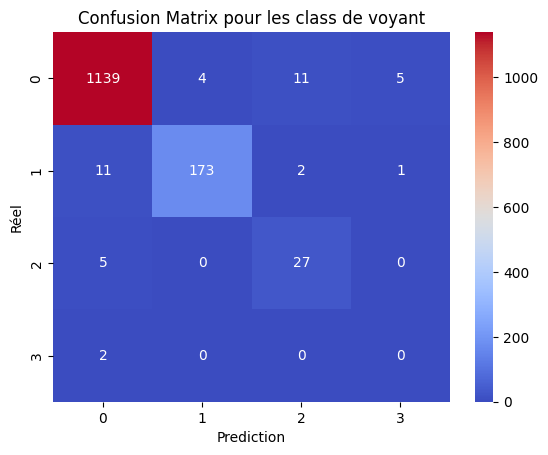

In [118]:
conf_matrix_rl = confusion_matrix(y_test, y_pred_rl)

sns.heatmap(conf_matrix_rl, annot=True, fmt='d', cmap='coolwarm')
plt.xlabel('Prediction')
plt.ylabel('Réel')

plt.title('Confusion Matrix pour les class de voyant')
plt.show()

# 3- Enregistrement du modele

In [119]:

# Enregistrer le modèle dans un fichier
joblib.dump(best_model_xgbc, 'best_model_avion_full_compo.pkl')

['best_model_avion_full_compo.pkl']

# 4- Essai de modele avec serie temporelle

In [120]:
liste_pour_lag = [      
       'usure_nouvelle_max_Ailerons', 
       'usure_nouvelle_max_Autopilote',
       'usure_nouvelle_max_Détecteurs_de_fumée',
       'usure_nouvelle_max_Empennage', 
       'usure_nouvelle_max_Flaps',
       'usure_nouvelle_max_Freins',
       'usure_nouvelle_max_Gouvernail_de_direction',
       'usure_nouvelle_max_Générateur_électrique',
       'usure_nouvelle_max_Hublots', 
       'usure_nouvelle_max_Ordinateur_de_vol',
       'usure_nouvelle_max_Porte_cargo', 
       'usure_nouvelle_max_Portes_passagers',
       'usure_nouvelle_max_Radar_météorologique',
       'usure_nouvelle_max_Réacteur_droit',
       'usure_nouvelle_max_Réacteur_gauche',
       'usure_nouvelle_max_Siège_copilote', 
       'usure_nouvelle_max_Siège_pilote',
       'usure_nouvelle_max_Spoilers', 
       'usure_nouvelle_max_Système_anti-givre',
       'usure_nouvelle_max_Système_d\'alerte_de_proximité_au_sol_(GPWS)',
       'usure_nouvelle_max_Système_d\'annonce_publique',
       'usure_nouvelle_max_Système_d\'approvisionnement_en_eau',
       'usure_nouvelle_max_Système_d\'atterrissage_automatique',
       'usure_nouvelle_max_Système_d\'extinction_d\'incendie',
       'usure_nouvelle_max_Système_de_commande_des_gaz',
       'usure_nouvelle_max_Système_de_communication_radio',
       'usure_nouvelle_max_Système_de_conditionnement_d\'air',
       'usure_nouvelle_max_Système_de_contrôle_de_vol',
       'usure_nouvelle_max_Système_de_contrôle_des_surfaces_de_vol',
       'usure_nouvelle_max_Système_de_divertissement_en_vol',
       'usure_nouvelle_max_Système_de_gestion_de_carburant',
       'usure_nouvelle_max_Système_de_gestion_électrique',
       'usure_nouvelle_max_Système_de_navigation',
       'usure_nouvelle_max_Système_de_pressurisation',
       'usure_nouvelle_max_Système_de_surveillance_du_trafic_aérien',
       'usure_nouvelle_max_Système_hydraulique_principal',
       'usure_nouvelle_max_Systèmes_d\'oxygène_d\'urgence',
       'usure_nouvelle_max_Toilettes',
       'usure_nouvelle_max_Train_d\'atterrissage_avant',
       'usure_nouvelle_max_Train_d\'atterrissage_principal',
       'usure_nouvelle_max_Unité_de_gestion_de_l\'air',
       'usure_nouvelle_max_Éclairage_d\'urgence',
       'usure_nouvelle_max_Éclairage_de_cabine',
       'usure_nouvelle_max_Éclairage_de_la_cabine',
       'usure_nouvelle_mean_Ailerons', 
       'usure_nouvelle_mean_Autopilote',
       'usure_nouvelle_mean_Détecteurs_de_fumée',
       'usure_nouvelle_mean_Empennage', 
       'usure_nouvelle_mean_Flaps',
       'usure_nouvelle_mean_Freins',
       'usure_nouvelle_mean_Gouvernail_de_direction',
       'usure_nouvelle_mean_Générateur_électrique',
       'usure_nouvelle_mean_Hublots', 
       'usure_nouvelle_mean_Ordinateur_de_vol',
       'usure_nouvelle_mean_Porte_cargo',
       'usure_nouvelle_mean_Portes_passagers',
       'usure_nouvelle_mean_Radar_météorologique',
       'usure_nouvelle_mean_Réacteur_droit',
       'usure_nouvelle_mean_Réacteur_gauche',
       'usure_nouvelle_mean_Siège_copilote',
       'usure_nouvelle_mean_Siège_pilote', 
       'usure_nouvelle_mean_Spoilers',
       'usure_nouvelle_mean_Système_anti-givre',
       'usure_nouvelle_mean_Système_d\'alerte_de_proximité_au_sol_(GPWS)',
       'usure_nouvelle_mean_Système_d\'annonce_publique',
       'usure_nouvelle_mean_Système_d\'approvisionnement_en_eau',
       'usure_nouvelle_mean_Système_d\'atterrissage_automatique',
       'usure_nouvelle_mean_Système_d\'extinction_d\'incendie',
       'usure_nouvelle_mean_Système_de_commande_des_gaz',
       'usure_nouvelle_mean_Système_de_communication_radio',
       'usure_nouvelle_mean_Système_de_conditionnement_d\'air',
       'usure_nouvelle_mean_Système_de_contrôle_de_vol',
       'usure_nouvelle_mean_Système_de_contrôle_des_surfaces_de_vol',
       'usure_nouvelle_mean_Système_de_divertissement_en_vol',
       'usure_nouvelle_mean_Système_de_gestion_de_carburant',
       'usure_nouvelle_mean_Système_de_gestion_électrique',
       'usure_nouvelle_mean_Système_de_navigation',
       'usure_nouvelle_mean_Système_de_pressurisation',
       'usure_nouvelle_mean_Système_de_surveillance_du_trafic_aérien',
       'usure_nouvelle_mean_Système_hydraulique_principal',
       'usure_nouvelle_mean_Systèmes_d\'oxygène_d\'urgence',
       'usure_nouvelle_mean_Toilettes',
       'usure_nouvelle_mean_Train_d\'atterrissage_avant',
       'usure_nouvelle_mean_Train_d\'atterrissage_principal',
       'usure_nouvelle_mean_Unité_de_gestion_de_l\'air',
       'usure_nouvelle_mean_Éclairage_d\'urgence',
       'usure_nouvelle_mean_Éclairage_de_cabine',
       'usure_nouvelle_mean_Éclairage_de_la_cabine', 
       'time_en_air',
       'temp', 
       'pressure', 
       'vibrations', 
       'temps_de_vol_cumule',
       'nb_jours_maint', 
       'nb_jours_service',
       'type_model',
       'en_maintenance'
       ]


In [121]:
# Création des valeurs décalées (lagged values)

# Nombre de jour pour voir l'évolution temporel
nb_vol_etude = 6

for var in liste_pour_lag:

    for lag in range(1, nb_vol_etude+1):

        df[f'{var}_lag_{lag}'] = df[var].shift(lag)


C:\Users\dimle\AppData\Local\Temp\ipykernel_31120\1589254840.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{var}_lag_{lag}'] = df[var].shift(lag)
C:\Users\dimle\AppData\Local\Temp\ipykernel_31120\1589254840.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{var}_lag_{lag}'] = df[var].shift(lag)
C:\Users\dimle\AppData\Local\Temp\ipykernel_31120\1589254840.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Con

In [122]:
list_drop = []
for i in df.columns:

    if i in X.columns:
        pass
    else:
        list_drop.append(i)

In [123]:
# Suppression des lignes avec des valeurs manquantes dues aux décalages des jours
df = df.dropna()

X=df

# Séparation des caractéristiques et de la cible
y = df['etat_voyant'] 


In [124]:
# Division en ensembles d'entraînement et de test
split_date = datetime(2024, 7, 19)

# ajuster en fonction de votre dataset
X_train = X[df['measure_day_'] < split_date]
X_test = X[df['measure_day_'] >= split_date]
y_train = y[df['measure_day_'] < split_date]
y_test = y[df['measure_day_'] >= split_date]


In [125]:

X = df.drop(list_drop, axis=1)

In [126]:
# Entraînement du modèle
RL_model = XGBClassifier()


In [127]:
# Préparation des transformateurs pour les caractéristiques numériques
numeric_transformer_std = (ImbPipeline( steps= [
    ('stdScaller', StandardScaler())
]))

categ_transformer_onehot = (ImbPipeline( steps= [
    ('OneHot', OneHotEncoder())
]))

categ_transformer_bin = (ImbPipeline( steps= [
    ('bina', OrdinalEncoder())
]))


# Combinaison des transformation pour le preprocessing
preprocessor = ColumnTransformer(
    transformers= [
        ('num_std', numeric_transformer_std, features_std),
        ('cat_oneHot', categ_transformer_onehot, features_oneHot),
        ('cat_bin', categ_transformer_bin, features_binar)
    ]
)

pipeline_reg_log = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(k_neighbors=1, random_state=42)),
    ('model', RL_model)
])


In [128]:
pipeline_reg_log.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_std',
                                                  Pipeline(steps=[('stdScaller',
                                                                   StandardScaler())]),
                                                  ['usure_nouvelle_max_Ailerons',
                                                   'usure_nouvelle_max_Autopilote',
                                                   'usure_nouvelle_max_Détecteurs_de_fumée',
                                                   'usure_nouvelle_max_Empennage',
                                                   'usure_nouvelle_max_Flaps',
                                                   'usure_nouvelle_max_Freins',
                                                   'usure_nouvelle_max_Gouvernail_de_d...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])

In [129]:
# Prédiction et évaluation
y_pred = pipeline_reg_log.predict(X_test)

In [130]:
accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.98


In [131]:
class_report_rl = classification_report(y_test, y_pred)

print(class_report_rl)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       691
           1       0.97      0.97      0.97       128
           2       0.89      0.77      0.83        31
           3       0.00      0.00      0.00         0

    accuracy                           0.98       850
   macro avg       0.71      0.68      0.70       850
weighted avg       0.98      0.98      0.98       850



c:\Users\dimle\Documents\clone_repo\preventive_maintenance\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dimle\Documents\clone_repo\preventive_maintenance\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dimle\Documents\clone_repo\preventive_maintenance\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

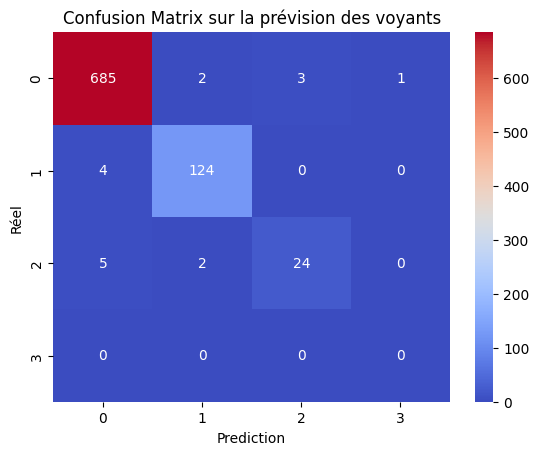

In [132]:
conf_matrix_rl = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix_rl, annot=True, fmt='d', cmap='coolwarm')
plt.xlabel('Prediction')
plt.ylabel('Réel')

plt.title('Confusion Matrix sur la prévision des voyants')
plt.show()

# 5- Enregistrement model fullcompo avec le timeseries

In [133]:

# Enregistrer le modèle dans un fichier
joblib.dump(best_model_xgbc, 'best_model_avion_full_compo_timeSeries.pkl')

['best_model_avion_full_compo_timeSeries.pkl']

In [136]:
# colonne à mettre en entrée du model
len(X_test.columns)

682

# 6- Enregistrement dans la bdd des prediction sur la table logs_vols